In [7]:
import numpy as np
import pandas as pd
import glob

In [ ]:
# Print the size in MB of the celsius array
print(celsius.nbytes / 1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius * 9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)

In [3]:
# Create empty list: dfs
dfs = []

# Loop over 'WDI.csv'
for chunk in pd.read_csv('./data/WDI.csv', chunksize=1000):
    # Create the first Series
    is_urban = chunk['Indicator Name']=='Urban population (% of total)'
    # Create the second Series
    is_AUS = chunk['Country Code']=='AUS'

    # Create the filtered chunk: filtered
    filtered = chunk.loc[is_urban & is_AUS]

    # Append the filtered chunk to the list dfs
    dfs.append(filtered)

92
36


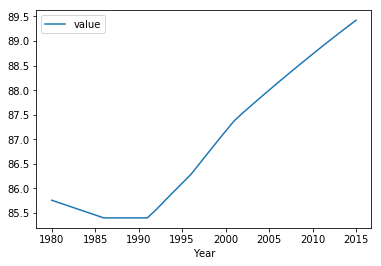

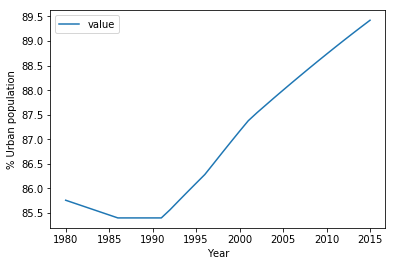

In [5]:
import matplotlib.pyplot as plt
# Print length of list dfs
print(len(dfs))

# Apply pd.concat to dfs: df
df = pd.concat(dfs)

# Print length of DataFrame df
print(len(df))

# Call df.plot.line with x='Year' and y='value'
df.plot.line(x='Year', y='value')
plt.ylabel('% Urban population')

# Call plt.show()
plt.show()

Bureau of Transportation Statistics

In [6]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY']>0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)

5


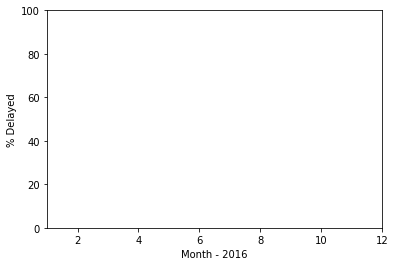

In [10]:
# filenames = glob.glob('./data/flightdelays//*')
# Define the generator: dataframes
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]
print(len(monthly_delayed))
# Create the plot
x = range(1,13)
# plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,12))
plt.ylim((0,100))
plt.show()

In [ ]:
from dask import delayed

# vs generator expression

# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

In [ ]:
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

# energy i.e. texas

In [ ]:
# Call da.from_array():  energy_dask
# np.genfromtxt('./data/texas/')
energy_dask = da.from_array(energy, chunks=energy.shape[0]//4)

# Print energy_dask.chunks
print(energy_dask.chunks)

# Print Dask array average and then NumPy array average
print(energy_dask.mean().compute())
print(energy.mean())

In [ ]:
# Import time
import time

# Call da.from_array() with arr: energy_dask4
energy_dask4 = da.from_array(energy, chunks=energy.shape[0]//4)

# Print the time to compute standard deviation
t_start = time.time()
std_4 = energy_dask4.std().compute()
t_end = time.time()
print((t_end - t_start) * 1.0e3)

The one-dimensional array load_2001 holds the total electricity load for the state of Texas sampled every 15 minutes for the entire year 2001 (35040 samples in total). The one-dimensional array load_recent holds the corresponding data sampled for each of the years 2013 through 2015 (i.e., 105120 samples consisting of the samples from 2013, 2014, & 2015 in sequence). None of these years are leap years, so each year has 365 days. Observe also that there are 96 intervals of duration 15 minutes in each day.

In [ ]:
# Reshape load_recent to three dimensions: load_recent_3d
load_recent_3d = load_recent.reshape((3,365,96))

# Print mean value of load_recent_3d
print(load_recent_3d.mean())

For this exercise, the monthly average maximum temperature (degrees Celsius) data on a 10km grid has been downloaded from NOAA http://www.noaa.gov/ for the continental US.

The data is stored in separate HDF5 files from 2008 to 2011. Your job is to use h5py to connect to the datasets and prepare a list of Dask arrays where each element is one year of data. The list of filenames is provided for you as filenames. The chunksizes have been chosen to optimize reading data from disk.

In [ ]:
# Import h5py and dask.array
import h5py
import dask.array as da

# List comprehension to read each file: dsets
dsets = [h5py.File(f)['/tmax'] for f in filenames]

# List comprehension to make dask arrays: monthly
monthly = [da.from_array(d, chunks=(1,444,922)) for d in dsets]

Now that we have a list of Dask arrays, your job is to call da.stack() to make a single Dask array where month and year are in separate dimensions. You'll also read the climatology data set, which is the monthly average max temperature again from 1970 to 2000.

In [ ]:
# Stack with the list of dask arrays: by_year
by_year = da.stack(monthly, axis=0)

In [ ]:
# Compute the difference: diff
diff = (by_year - climatology) * 9/5
# Compute the average over last two axes: avg
avg = da.nanmean(diff, axis=(-1,-2)).compute()
# Plot the slices [:,0], [:,7], and [:11] against the x values
x = range(2008,2012)
f, ax = plt.subplots()
ax.plot(x,avg[:,0], label='Jan')
ax.plot(x,avg[:,7], label='Aug')
ax.plot(x,avg[:,11], label='Dec')
ax.axhline(0, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Difference (degrees Fahrenheit)')
ax.legend(loc=0)
plt.show()

In [ ]:
Now that we have two Dask arrays, one for the monthly average temperature from 2008 to 2011 and one for the 30-year climatology average we can compute the deviation from the climatology by taking a difference. The climatology data will be broadcast into each each year of the outer dimension of by_year.

Your job is to compute the difference, convert it to Fahrenheit, and take the average over the latitude and longitude dimensions. For this you'll use the da.nanmean() function, which ignores missing values. Finally, you'll make a plot of the monthly average deviation each year for January, August, and December.

In [ ]:
# Read from 'WDI.csv': df
df = dd.read_csv('./data/WDI.csv')

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df.loc[toxins & region]

In [ ]:
# Grouby filtered by the 'Year' column: yearly
yearly = filtered.groupby('Year')

# Aggregate the mean of the groupby object: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean.compute()

# Plot the 'value' column with .plot.line()
result['value'].plot.line()
plt.ylabel('% pop exposed')
plt.show()


In [ ]:
# Define a function with df as input: by_region
def by_region(df):

    # Create the toxins array
    toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'

    # Create the y2015 array
    y2015 = df['Indicator Code'] == 2015

    # Filter the DataFrame and group by the 'Region' column
    regions = df.loc[toxins & y2015].groupby('Region')

    # Return the mean of the 'value' column of regions
    return regions['value'].mean()


In [ ]:
# Call time.time()
t0 = time.time()

# Read 'WDI.csv' into df
df = pd.read_csv('WDI.csv')

# Group df by region: result
result = by_region(df)

# Call time.time()
t1 = time.time()

# Print the execution time
print((t1-t0)*1000)

In [ ]:
# Read all .csv files: df
df = dd.read_csv('taxi/*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

In [ ]:
# Filter rows where payment_type == 1: credit
credit = df.loc[df['payment_type']==1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

In [ ]:
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

In [ ]:
The sotu/ directory contains text files for each of the 45 US Presidents as of 2017. These text files contain the State of the Union addresses delivered by each president. The texts of the speeches were obtained from the American Presidency Project.

In [ ]:
from dask import bag as db
# Glob filenames matching 'sotu/*.txt' and sort
filenames = glob.glob('./data/sotu/*.txt')
filenames = sorted(filenames)

# Load filenames as Dask bag with db.read_text(): speeches
speeches = db.read_text(filenames)

# Print number of speeches with .count()
print(speeches.count().compute())

In [ ]:
# Call .take(1): one_element
one_element = speeches.take(1)

# Extract first element of one_element: first_speech
first_speech = one_element[0]

# Print type of first_speech and first 60 characters
print(type(first_speech))
print(first_speech[:60])

In [ ]:
# Call .str.split(' ') from speeches and assign it to by_word
by_word = speeches.str.split(' ')

# Map the len function over by_word and compute its mean
n_words = by_word.map(len)
avg_words = n_words.mean()

# Print the type of avg_words and value of avg_words.compute()
print(type(avg_words))
print(avg_words.compute())

In [ ]:
# Convert speeches to lower case: lower
lower = speeches.str.lower()

# Filter lower for the presence of 'health care': health
health = lower.filter(lambda s:'health care' in s)

# Count the number of entries : n_health
n_health = health.count()

# Compute and print the value of n_health
print(n_health.compute())

A collection of JSON files for Congressional bills have been downloaded from GovTrack.us. All bills presented during each congressional session from 1973 - 2017 are provided in separate files.
https://www.govtrack.us/developers/api

Your job is to read the bills*.json files into a Dask Bag. You'll then use the JSON module to map the text of each file into Python dictionaries. 

In [ ]:
# Call db.read_text with congress/bills*.json: bills_text
bills_text = db.read_text('./data/congress/bills*.json')

In [ ]:
# Compare the value of the 'current_status' key to 'enacted_veto_override'
def veto_override(d):
    return d['current_status'] == 'enacted_veto_override'

# Filter the bills: overridden
overridden = bills_dicts.filter(veto_override)

# Print the number of bills retained
print(overridden.count().compute())

# Get the value of the 'title' key
titles = overridden.pluck('title')

# Compute and print the titles
print(titles.compute())

In [ ]:
# Define a function lifespan that takes a dictionary d as input
def lifespan(d):
    # Convert to datetime
    current = pd.to_datetime(d['current_status_date'])
    intro = pd.to_datetime(d['introduced_date'])

    # Return the number of days
    return (current - intro).days

# Filter bills_dicts: days
days = bills_dicts.filter(lambda s:s['current_status']=='enacted_signed').map(lifespan)

# Print the mean value of the days Bag
print(days.mean().compute())

## CASE STUDY!!!!

In [ ]:
from dask import delayed

# Define @delayed-function read_flights
@delayed
def read_flights(filename):

    # Read in the DataFrame: df
    df = pd.read_csv(filename, parse_dates=['FL_DATE'])

    # Replace 0s in df['WEATHER_DELAY'] with np.nan
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0, np.nan)

    # Return df
    return df

In [ ]:
# Loop over filenames with index filename
for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
print(flight_delays['WEATHER_DELAY'].mean().compute())

For this exercise, daily weather data is provided from 2016 for 5 US cities: Atlanta, Denver, Dallas-Fort Worth, Orlando, and Chicago. The weather data comes from Weather Underground and is found in separate CSV files labelled by airport code (e.g., ATL.csv). The list filenames contains the names of these 5 files. The ultimate goal is to correlate the flight delays with weather events from each day of 2016.

As with the flight-delays data, you'll need to clean the weather data as it is read in. Your job is to define a function that loads a DataFrame from a file, cleans the DataFrame's 'PrecipitationIn' column, and appends an 'Airport' column with the appropriate airport code for each record.

In [ ]:
# Define @delayed-function read_weather with input filename
@delayed
def read_weather(filename):
    # Read in filename: df
    df = pd.read_csv(filename, parse_dates=['Date'])

    # Clean 'PrecipitationIn'
    df['PrecipitationIn'] = pd.to_numeric(df['PrecipitationIn'], errors='coerce')

    # Create the 'Airport' column
    df['Airport'] = filename.split('.')[0]

    # Return df
    return df

In [ ]:
The list filenames contains the names of the CSV files of weather data abelled by airport code for Atlanta, Denver, Dallas-Fort Worth, Orlando, and Chicago. 

In [ ]:
from dask import dataframe as dd

# regex for filenames

# filenames = {["A"-"Z"]{3}.csv}
# Loop over filenames with filename
for filename in filenames:
    # Invoke read_weather on filename; append resultt to weather_dfs
    weather_dfs.append(read_weather(filename))

# Call dd.from_delayed() with weather_dfs: weather
weather = dd.from_delayed(weather_dfs)

# Print result of weather.nlargest(1, 'Max TemperatureF')
print(weather.nlargest(1, 'Max TemperatureF').compute())

In [ ]:
# Make cleaned Boolean Series from weather['Events']: is_snowy
is_snowy = weather['Events'].str.contains('Snow').fillna(False)

In [ ]:
def percent_delayed(df):
    return (df['WEATHER_DELAY'].count() / len(df)) * 100

# Print time in milliseconds to compute percentage_delayed on weather_delays
t_start = time.time()
print(percent_delayed(weather_delays).compute())
t_end = time.time()
print((t_end-t_start)*1000)

# Call weather_delays.persist(): persisted_weather_delays
persisted_weather_delays = weather_delays.persist()

# Print time in milliseconds to compute percentage_delayed on persisted_weather_delays
t_start = time.time()
print(percent_delayed(persisted_weather_delays).compute())
t_end = time.time()
print((t_end-t_start)*1000)

In [ ]:
# Group persisted_weather_delays by 'Events': by_event
by_event = persisted_weather_delays.groupby('Events')

# Count 'by_event['WEATHER_DELAY'] column & divide by total number of delayed flights
pct_delayed = by_event['WEATHER_DELAY'].count() / persisted_weather_delays['WEATHER_DELAY'].count() * 100

# Compute & print five largest values of pct_delayed
print(pct_delayed.nlargest(5).compute())

# Calculate mean of by_event['WEATHER_DELAY'] column & return the 5 largest entries: avg_delay_time
avg_delay_time = by_event['WEATHER_DELAY'].mean().nlargest(5)

# Compute & print avg_delay_time
print(avg_delay_time.compute())